In [97]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#  Transformation to $k_x(k_y)$ space of the RHEED image
This notebook shows how to use `Ewald` module to transform the RHEED image to the $k_x(k_y)$ space.

In [98]:
import xrheed
from xrheed.io import load_data

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from pathlib import Path

## Prepare the RHEED data
Although it is not necessary it is recommended to first prepare the RHEED data by proper alignment and also test the spot position with the Ewald calculated points as shown bellow.

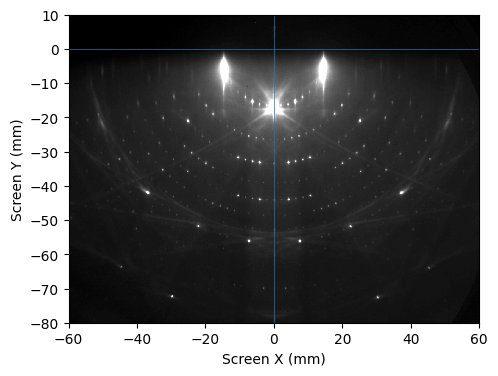

In [99]:
image_dir = Path("example_data")
image_path = image_dir / "Si_111_7x7_112_phi_00.raw"

rheed_image = load_data(image_path, plugin="dsnp_arpes_raw")

# Rotate the image
rheed_image.ri.rotate(-0.4)

# Apply automatic center search again after rotation
rheed_image.ri.apply_image_center(auto_center=True)

rheed_image.ri.screen_roi_width = 60
rheed_image.ri.screen_roi_height = 80

# Use automatic levels adjustment
rheed_image.ri.plot_image(auto_levels=0.5)

plt.show()

## Use high-pass filter
It is very usefull to use high pass filter before the transformation

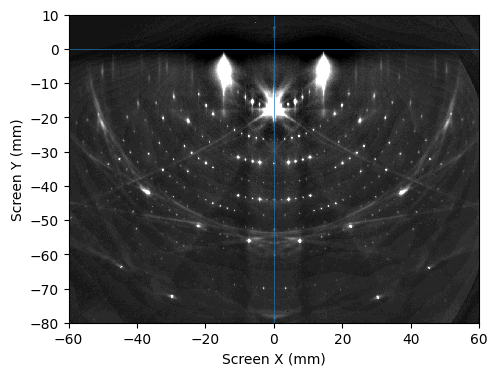

In [100]:
from xrheed.preparation.filters import high_pass_filter

sigma = 5.0 # in mm
threshold = 0.8

hp_rheed_image = high_pass_filter(rheed_image, sigma=sigma, threshold=threshold)

hp_rheed_image.ri.plot_image(auto_levels=1.0)
plt.show()

In [101]:
rheed_image = hp_rheed_image

## Adjust the beta angle and image vertical shift
Although this could be done later in Ewald object it is recommended to setup the image properly before the creation of Ewald class instance. 

In [102]:
from xrheed.preparation.alignment import find_incident_angle

# apply fine y shift 
shift_y = -2.4
rheed_image.ri.apply_image_center(center_x=0.0,
                                  center_y=shift_y)

rheed_image.ri.beta = find_incident_angle(rheed_image)

Transmission spot at: 15.26
Mirror spot at: -15.28
Spot distance: 30.53
Shadow edge: -0.01
Theta angle: 2.83


## Prepare the 2D lattice 

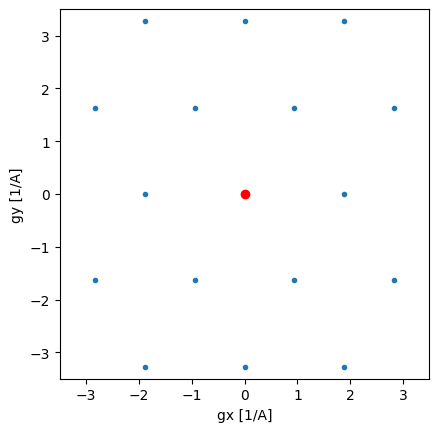

In [103]:
from xrheed.kinematics.lattice import Lattice

si_111 = Lattice.from_surface_hex(a=3.84)
si_111.rotate(30.0)
si_111.plot_inverse(space_size=3.5)
plt.show()

## Create an Ewald object
Create an instance of Ewald class using generated lattice and RHEED image

In [104]:
from xrheed.kinematics.ewald import Ewald

ew_si_111 = Ewald(si_111, rheed_image)

ew_si_111

  Ewald Radius: 69.87 1/A,
  alpha: 0.00 deg,
  beta: 2.83 deg,
  lattice_scale: 1.00,
  screen_scale: 9.04 px/mm,
  screen_sample_distance: 309.2 mm,
  shift_x: 0.00 mm,
  shift_y: 0.00 mm,
  b1 = [1.89, -0.00] 1/A,
  b2 = [-0.94, 1.64] 1/A,

## RHEED image with calculated spots plot
If the RHEED image is properly aligned and scaled (and the lattice matches the real crystal) there should be good match on the image, ash visible bellow.

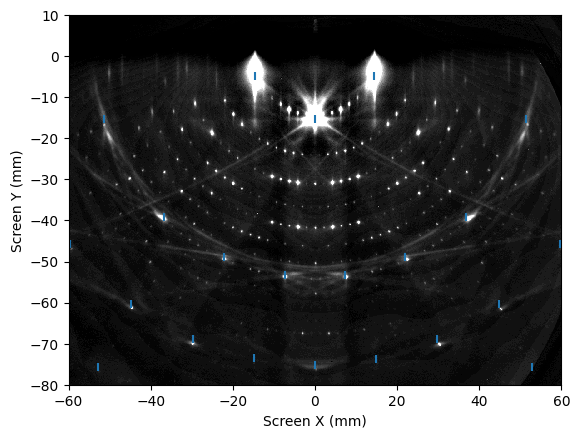

In [105]:
fig, ax = plt.subplots() 

ew_si_111.calculate_ewald()
ew_si_111.plot(ax=ax, 
               show_image=True,
               show_center_lines=False,
               auto_levels=1.0)
plt.show()

## Final transformation
The image could be transformed using `transform_to_kxky` function. Please note that the result image is no longer an RHEED image and `ri` accesories are not available anymore. Nonetheless, all attributes are copied form origin RHEED image.


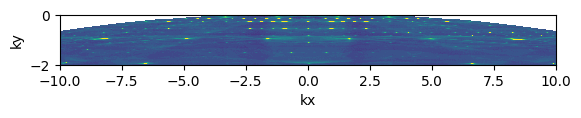

In [110]:
from xrheed.conversion.base import transform_to_kxky

trans_image = transform_to_kxky(rheed_image)

fig, ax = plt.subplots() 

trans_image.plot(ax=ax, vmin=5, vmax=30, add_colorbar=False)
ax.set_xlim(-10,10)
ax.set_ylim(-2,0)
ax.set_aspect(1.0)
plt.show()

## Merging several transformed images

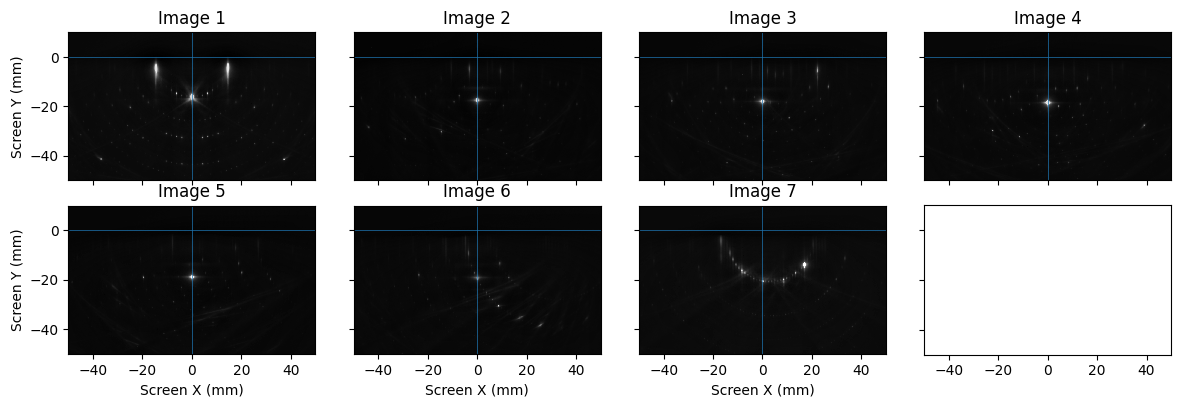

In [149]:
from xrheed.plotting.overview import plot_images


image_dir = Path("example_data")
image_paths = image_dir.glob("Si_111_7x7_112_phi_*.raw")


beta = 2.8
center_x = -0.5
center_y = 1.0

# Define alphas for each image (manipulator misalignment is included here)
alphas = np.linspace(0.0, 29.0, 7)
rheed_images = []


for i, image_path in enumerate(image_paths):
    rheed_image = load_data(image_path, plugin="dsnp_arpes_raw")
    rheed_image.ri.rotate(-0.4)
    
    rheed_image.ri.apply_image_center(center_x, center_y)
    rheed_image.ri.beta = beta 
    rheed_image.ri.alpha = alphas[i]

    rheed_image = high_pass_filter(rheed_image, sigma=5.0, threshold=0.8)

    rheed_images.append(rheed_image)


plot_images(rheed_images, ncols=4)

plt.show()


- test the last image if it is aligned properly
- use Ewald on it

then adjust if necesaryy

finalyy transform each using rotation enabled

merge them into one and use also some lattice symmetry